# Assignment 2

**Due to**: 9th November, 2020

**Credits**: Andrea Galassi, Federico Ruggeri, Paolo Torroni

**Summary**: Word embeddings, from sparse to dense representations

# Intro

In this assignment we will explore text encoding techniques, spanning from sparse representations, such as bag-of-words, to dense representations.

In particular, we will see:

*   Building a vocabulary
*   Building a word-word co-occurrence matrix
*   Defining a similarity metric: cosine similarity
*   Embedding visualization and analysis of their semantic properties
*   Better sparse representations via PPMI weighting
*   Loading pre-trained dense word embeddings (Word2Vec, GloVe)
*   Checking out-of-vocabulary (OOV) terms
*   Handling OOV terms



# Initial Setup

First of all, we need to import some useful packages that we will use during this hands-on session.

In [1]:
# system packages
import os
import shutil
import sys

# data and numerical management packages
import pandas as pd
import numpy as np

# useful during debugging (progress bars)
from tqdm import tqdm

# [Part I] Sparse embeddings

As you know, working with text inherently requires a conversion step, formally known as embedding, that simply allows us to pass from string-like text to corresponding numerical representation. 

One of the most notable embedding method is the bag-of-words one (BoW). We simply count the occurrence of each word in the given corpus so as to build some useful data structures (matrices) that may give us some general idea of how the dataset is organized. For example, we can check where a particular word appears or, in a reversed perspective, identify the most common terms in each given document.

This type of reasoning is directly related to how meaning is assigned to words. In particular, it is the environment itself, enclosing a word, that gives a specific meaning to it. Thus, we look for numerical encoding methods that reflect such point of view.

Before diving into embedding analysis, we need to prepare a dataset and, most importantly, extract a vocabulary!

## Prepare a dataset for experiments

We will use the IMDB dataset of previous assignment. As you already know, it is a dataset of 50k sentences used for sentiment analysis. In particular, half of them (25k) is labelled as containing positive sentiment, whereas the remaining half are sentences of negative polarity.

Contrarily to first assignment, we will ignore sentiment labels and we will focus only on learning a proper word embedding representation.

### Download and extraction

We start by downloading the dataset and extract it to a folder.

In [ ]:
from urllib import request
import tarfile

# Config
print("Current work directory: {}".format(os.getcwd()))

dataset_folder = os.path.join(os.getcwd(), "Datasets")

if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)

url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset_path = os.path.join(dataset_folder, "Movies.tar.gz")

print(dataset_path)

def download_dataset(download_path, url):
    if not os.path.exists(download_path):
        print("Downloading dataset...")
        request.urlretrieve(url, download_path)
        print("Download complete!")

def extract_dataset(download_path, extract_path):
    print("Extracting dataset... (it may take a while...)")
    with tarfile.open(download_path) as loaded_tar:
        loaded_tar.extractall(extract_path)
    print("Extraction completed!")

# Download
download_dataset(dataset_path, url)

# Extraction
extract_dataset(dataset_path, dataset_folder)


Current work directory: /content
/content/Datasets/Movies.tar.gz
Download complete!
Extracting dataset... (it may take a while...)


Feel free to check the dataset folder content. Usually, the README file is a good starting point (if it exists and its well done, which is not so common!).

Just like in the first assignment, we need a high level view of the dataset that is helpful to our needs. Thus, we will encode the dataset into a [pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

In [2]:

# Config
dataset_name = "aclImdb"
debug = True

def encode_dataset(dataset_name, debug=True):
    dataframe_rows = []

    for split in tqdm(['train', 'test']):
        for sentiment in ['pos', 'neg']:
            folder = os.path.join(os.getcwd(), "Datasets", dataset_name, split, sentiment)
            for filename in os.listdir(folder):
                file_path = os.path.join(folder, filename)
                try:
                    if os.path.isfile(file_path):
                        # open the file
                        with open(file_path, mode='r', encoding='utf-8') as text_file:
                            # read it and extract informations
                            text = text_file.read()
                            score = filename.split("_")[1].split(".")[0]
                            file_id = filename.split("_")[0]

                            num_sentiment = -1

                            if sentiment == "pos" : num_sentiment = 1
                            elif sentiment == "neg" : num_sentiment = 0

                            # create single dataframe row
                            dataframe_row = {
                                "file_id": file_id,
                                "score": score,
                                "sentiment": num_sentiment,
                                "split": split,
                                "text": text
                            }

                            # print detailed info for the first file
                            if debug:
                                print(file_path)
                                print(filename)
                                print(file_id)
                                print(text)
                                print(score)
                                print(sentiment)
                                print(split)
                                print(dataframe_row)
                                debug = False
                            dataframe_rows.append(dataframe_row)

                except Exception as e:
                    print('Failed to process %s. Reason: %s' % (file_path, e))
                    sys.exit(0)

    folder = os.path.join(os.getcwd(), "Datasets", "Dataframes", dataset_name)
    if not os.path.exists(folder):
        os.makedirs(folder)

    # transform the list of rows in a proper dataframe
    df = pd.DataFrame(dataframe_rows)
    df = df[["file_id",
                        "score",
                        "sentiment",
                        "split",
                        "text"]]
    dataframe_path = os.path.join(folder, dataset_name + ".pkl")
    df.to_pickle(dataframe_path)

    return df


# Encoding
print("Encoding dataset...")
df = encode_dataset(dataset_name, debug)
print("Encoding completed!")

  0%|          | 0/2 [00:00<?, ?it/s]

Encoding dataset...
/home/pptr/master/2year/1sem/NLP/assignments/assignment2/Datasets/aclImdb/train/pos/10589_10.txt
10589_10.txt
10589
I enjoyed Longstreet, which followed in the steps of Raymond Burr's successful Ironside TV series and was intended to give it competition. But this show was canceled after one season because it was decided--I believe wrongly--that Longstreet was not able to compete with Mr. Burr's Ironside.<br /><br />I may add that the pilot for this show was especially well done and very memorable. I hope that a box set of Longstreet will appear.<br /><br />Writers should note that this story idea was only briefly explored here and that much more could and should be done to show the play and interplay of disabilities on TV.
10
pos
train
{'file_id': '10589', 'score': '10', 'sentiment': 1, 'split': 'train', 'text': "I enjoyed Longstreet, which followed in the steps of Raymond Burr's successful Ironside TV series and was intended to give it competition. But this show wa

100%|██████████| 2/2 [00:10<00:00,  5.30s/it]


Encoding completed!


### Loading and Visualization

The next step is to load the dataset and inspect some of its elements in order to have an idea of the general content. We will use **pandas** library for dataset loading as follows.

In [3]:
# Inspection

print("Dataset size: {}".format(df.shape)) # (50000, 5)
print("Dataset columns: {}".format(df.columns.values)) # ['file_id', 'score', 'sentiment', 'split', 'text]

print("Classes distribution:\n{}".format(df.sentiment.value_counts())) # [0: 25000, 1: 25000]

print("Some examples: {}".format(df.iloc[:5]))

Dataset size: (50000, 5)
Dataset columns: ['file_id' 'score' 'sentiment' 'split' 'text']
Classes distribution:
1    25000
0    25000
Name: sentiment, dtype: int64
Some examples:   file_id score  sentiment  split  \
0   10589    10          1  train   
1    2964     8          1  train   
2    7886    10          1  train   
3    4267     8          1  train   
4    4910     8          1  train   

                                                text  
0  I enjoyed Longstreet, which followed in the st...  
1  BASEketball is an extremely funny movie that d...  
2  Okay, I am a fan of the Nightmare series and e...  
3  During a Kurt Weill celebration in Brooklyn, W...  
4  This very good movie crackles with tension. Th...  


Feel free to inspect the dataset as you wish in the following code space!

In [4]:
""" YOUR CODE HERE """


' YOUR CODE HERE '

### [Optional] A quick simplification

Since the dataset is quite large, the embedding related methods, such as co-occurrence matrix construction, may take a while or may require ad hoc solutions. For instance, if we consider the whole dataset (50k sentences) the vocabulary should be around 160k terms and we don't have sufficient memory to load a (160k, 160k) co-occurrence matrix.

For the purpose of this assignment, we can rely on a small slice of the dataset.
In this way, we can get results in small amount of time. Nonetheless, feel free
to work with the whole dataset! Suggestions on how to handle this scenario are
given below when required.

Select the amount of dataset samples you want to keep and re-define the dataset as follows.

In [5]:
samples_amount = 500

# This type of slicing is not mandatory,
# but it is sufficient to our purposes
np.random.seed(42)
random_indexes = np.random.choice(np.arange(df.shape[0]),
                                  size=samples_amount,
                                  replace=False)

df = df.iloc[random_indexes]

print('New dataset size: ', df.shape)

New dataset size:  (500, 5)


## Building the Vocabulary

At this point we can build the word vocabulary of our dataset. This information is the first step of any word embedding method: we need to know the set of atomic entities that build up our corpus.

**Definition**: a vocabulary is a collection of words occurring in a given dataset. More precisely, each word is recognized and assigned an index.

**Example**: Suppose you have the given toy corpus $D$: { "the cat is on the table" }

As you notice, the dataset is comprised of only one sentence: "the cat is on the table". The corresponding vocabulary (a possible one) will be:

V = {0: 'the', 1: 'cat', 2: 'is', 3: 'on', 4: 'table'}

In this case, indexing follows word order, but it is not mandatory!

**Important**: The most important thing to remember is that the vocabulary should always be the same one. Thus, make sure that the vocabulary creation routine always returns the same result!



### Some Cleaning

Before vocabulary creation, we have to do a little bit of text pre-processing so as to avoid spurious data.

Pre-processing is always an important step in any machine learning based task, since data quality is one of the crucial factors that lead to better performance. Models, even state-of-the-art ones, hardly achieve satisfying results if the dataset is very noisy.

**Types of pre-processing**: there are a lot of pre-processing steps that we can consider, either general or quite task- specific. Here we will rely on very standard and simple methods.

*    **Text to lower**: casing usually doesn't affect our task, but in some scenarios, such as part-of-speech tagging, might even be crucial.

*    **Replace special characters**: special characters are usually employed as variants of a single character like the spacing symbol ' '. 
In other cases (dates, etc..) special characters might have a specific meaning and should not be replaced.

*    **Text stripping**: it is important to filter out extra spaces to avoid unwanted distinctions between identical words, such as 'apple' and ' apple '.

There are a lot of pre-processing techniques, such as number replacing, lemmatization, stemming, spell correction, acronyms merge and so on. If you are interested you can check [here](https://medium.com/swlh/text-normalization-7ecc8e084e31) and [here](https://www.kdnuggets.com/2019/04/text-preprocessing-nlp-machine-learning.html) some good blogs about the topic.

**NOTE**: If you feel like there should be some additional pre-processing, feel free to modify this section as you please! Please, remember to provide additional comments to motivate your changes.

In [6]:
import re
from functools import reduce
import nltk
from nltk.corpus import stopwords

# Config

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
GOOD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
try:
    STOPWORDS = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    STOPWORDS = set(stopwords.words('english'))

def lower(text):
    """
    Transforms given text to lower case.
    Example:
    Input: 'I really like New York city'
    Output: 'i really like new your city'
    """

    return text.lower()

def replace_special_characters(text):
    """
    Replaces special characters, such as paranthesis,
    with spacing character
    """

    return REPLACE_BY_SPACE_RE.sub(' ', text)

def filter_out_uncommon_symbols(text):
    """
    Removes any special character that is not in the
    good symbols list (check regular expression)
    """

    return GOOD_SYMBOLS_RE.sub('', text)

def remove_stopwords(text):
    return ' '.join([x for x in text.split() if x and x not in STOPWORDS])


def strip_text(text):
    """
    Removes any left or right spacing (including carriage return) from text.
    Example:
    Input: '  This assignment is cool\n'
    Output: 'This assignment is cool'
    """

    return text.strip()

PREPROCESSING_PIPELINE = [
                          lower,
                          replace_special_characters,
                          filter_out_uncommon_symbols,
                          remove_stopwords,
                          strip_text
                          ]

# Anchor method

def text_prepare(text, filter_methods=None):
    """
    Applies a list of pre-processing functions in sequence (reduce).
    Note that the order is important here!
    """

    filter_methods = filter_methods if filter_methods is not None else PREPROCESSING_PIPELINE

    return reduce(lambda txt, f: f(txt), filter_methods, text)

# Pre-processing

print('Pre-processing text...')

print()
print('[Debug] Before:\n{}'.format(df.text[:3]))
print()

# Replace each sentence with its pre-processed version
df['text'] = df['text'].apply(lambda txt: text_prepare(txt))

print('[Debug] After:\n{}'.format(df.text[:3]))
print()

print("Pre-processing completed!")

Pre-processing text...

[Debug] Before:
33553    This movie has all the qualities to be good, S...
9427     Another demonstration of Kurosawa's genius, hi...
199      This is one horror movie based TV show that ge...
Name: text, dtype: object

[Debug] After:
33553    movie qualities good stan singing dancing fall...
9427     another demonstration kurosawas genius first c...
199      one horror movie based tv show gets right frid...
Name: text, dtype: object

Pre-processing completed!


### **Vocabulary Creation**

We are now ready to create the vocabulary! This task is up to you! Complete the below function and remember to follow mentioned requirements.

FYI, since the text has been pre-processed, space splitting should work correctly. 

Bare in mind that some packages offers tools for automatic vocabulary creation, such as Keras (check [keras.preprocessing.text.Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer)). 

**NOTE**: It is not mandatory to use the keras Tokenizer, we mention it so that you know there exist tools specific for this step.

**NOTE**: In this case, the vocabulary will start from index equal to 1, since the 0 slot is reserved to padding token. In order to pass vocabulary evaluation, you have to re-scale the vocabulary such that the first index is 0.

**NOTE**: If you are using the keras Tokenizer, remember to use its method <code> texts_to_sequences </code> for splitting, otherwise you might find terms that are not in the vocabulary! Please, check also its constructor argument <code> filters </code> since it defines a pre-processing regexp.

This easy task is just to let you know that is important to check the built vocabulary just to make sure everything is ok.

In [7]:
from collections import OrderedDict

# Function definition
def build_vocabulary(df):
    """
    Given a dataset, builds the corresponding word vocabulary.

    :param df: dataset from which we want to build the word vocabulary (pandas.DataFrame)
    :return:
      - word vocabulary: vocabulary index to word
      - inverse word vocabulary: word to vocabulary index
      - word listing: set of unique terms that build up the vocabulary
    """
    ### YOUR CODE HERE ###
    voc_inverted = {}
    current_index = 0
    df_text = np.array(df['text'])
    for i in range(df_text.shape[0]):
        df_text_split = df_text[i].split(' ')
        for word in df_text_split:
            if word not in voc_inverted:
                voc_inverted[word] = current_index
                current_index += 1
    
    voc = {v: k for k, v in voc_inverted.items()}
    
    return voc, voc_inverted, voc_inverted.keys()
 


# Testing
idx_to_word, word_to_idx, word_listing = build_vocabulary(df)

print('[Debug] Index -> Word vocabulary size: {}'.format(len(idx_to_word)))
print('[Debug] Word -> Index vocabulary size: {}'.format(len(word_to_idx)))

print('[Debug] Some words: {}'.format([(idx_to_word[idx], idx) for idx in np.arange(10) + 1]))

# Evaluation

def evaluate_vocabulary(idx_to_word, word_to_idx, word_listing, df, check_default_size=False):

    # Check size
    print("[Vocabulary Evaluation] Size checking...")

    assert len(idx_to_word) == len(word_to_idx)
    assert len(idx_to_word) == len(word_listing)

    # Check content
    print("[Vocabulary Evaluation] Content checking...")

    for i in tqdm(range(0, len(idx_to_word))):
        assert idx_to_word[i] in word_to_idx
        assert word_to_idx[idx_to_word[i]] == i

    # Check consistency
    print("[Vocabulary Evaluation] Consistency checking...")

    _, _, first_word_listing = build_vocabulary(df)
    _, _, second_word_listing = build_vocabulary(df)
    assert first_word_listing == second_word_listing

    # Check toy example
    print("[Vocabulary Evaluation] Toy example checking...")
    toy_df = pd.DataFrame.from_dict({
        'text': ["all that glitters is not gold", "all in all i like this assignment"]
    })
    _, _, toy_word_listing = build_vocabulary(toy_df)
    toy_valid_vocabulary = set(' '.join(toy_df.text.values).split())
    assert set(toy_word_listing) == toy_valid_vocabulary


print("Vocabulary evaluation...")
evaluate_vocabulary(idx_to_word, word_to_idx, word_listing, df)
print("Evaluation completed!") 

100%|██████████| 13940/13940 [00:00<00:00, 918754.19it/s]

[Debug] Index -> Word vocabulary size: 13940
[Debug] Word -> Index vocabulary size: 13940
[Debug] Some words: [('qualities', 1), ('good', 2), ('stan', 3), ('singing', 4), ('dancing', 5), ('falling', 6), ('funny', 7), ('think', 8), ('handled', 9), ('character', 10)]
Vocabulary evaluation...
[Vocabulary Evaluation] Size checking...
[Vocabulary Evaluation] Content checking...
[Vocabulary Evaluation] Consistency checking...
[Vocabulary Evaluation] Toy example checking...
Evaluation completed!


Feel free to inspect the vocabulary! To this purpose, you can use the following code space.

In [8]:
""" YOUR CODE HERE """


' YOUR CODE HERE '

### **Save the vocabulary**

Generally speaking, it is a good idea to save the dictionary in clear format. In this way you can quickly check for errors or useful words.

In this case, we will save the vocabulary dictionary in JSON format.

In [9]:
!pip install simplejson
import simplejson as sj

vocab_path = os.path.join(os.getcwd(), 'Datasets', dataset_name, 'vocab.json')

print("Saving vocabulary to {}".format(vocab_path))
with open(vocab_path, mode='w') as f:
    sj.dump(word_to_idx, f, indent=4)
print("Saving completed!")

Saving vocabulary to /home/pptr/master/2year/1sem/NLP/assignments/assignment2/Datasets/aclImdb/vocab.json
Saving completed!


## Building the Co-occurence Matrix

As we said at the beginning, embedding methods are based on the principle that similar words will be used in similar contexts. Thus, context information is crucial to determine the meaning of a word.

One basic approach, which falls under the category of sparse representations, is the **co-occurrence matrix**: for each word in the vocabulary we count the number of times each other word appears within the same context window. A simple example is given by image below.

![](https://drive.google.com/uc?export=view&id=1UknGoYvIBBA7ytkSlqm1NhF_lHt0iOwT)

In particular, the context window defines our notion of word context. Consider the following example:

<h3><center> The cat is on the table </center></h3>

We have to consider each word in the sentence and for each we have count words within the context window. Suppose a window of size 2, then we have for the word 'cat':

Current word: cat

Context words: [the, is, on]

Notice how we consider $W$ words back and ahead of current word, where $W$ is the window size.




Let's define the simplest version of a **co-occurrence matrix** based on word counting.

---

**Small dataset case**: If you selected a small slice of the dataset, you should have a vocabulary size that we can afford in terms of memory demand. Thus, you can easily instantiate the co-occurrence matrix and populate it iteratively.

---

**Large dataset case**: We have to work with sparse matrices due to the high vocabulary size and to the low amount of non-zero word counts. To this end, the [Scipy package](https://docs.scipy.org/doc/scipy/reference/sparse.html) allows us to easily define sparse matrices that can be converted ot numpy arrays (if we can).

**Suggestion**: The simplest way to build the co-occurrence matrix is via an incremental approach: we loop through dataset sentences, split into words and then count co-occurrences within the given window frame. Generally, combining this approach with sparse matrices is not so efficient (yet possible). However, Scipy offers [$\texttt{lil_matrix}$](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.lil_matrix.html#scipy.sparse.lil_matrix) sparse format that is suitable to this case. Anyway, check out other sparse formats, such as [$\texttt{csr_matrix}$](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix), and the corresponding building methods.

Working with $\texttt{lil_matrix}$ might take $\sim 1h$ of time to build the whole dataset co-occurrence matrix. It is also possibile to work with $\texttt{csr_matrix}$ but the approach is more complex (check the last example of the corresponding documentation page).


In [10]:
import scipy.sparse    # defines several types of efficient sparse matrices
import zipfile
import gc
import requests
import time

# Function definition

def co_occurrence_count(df, idx_to_word, word_to_idx, window_size=4):
    """
    Builds word-word co-occurrence matrix based on word counts.

    :param df: pre-processed dataset (pandas.DataFrame)
    :param idx_to_word: vocabulary map (index -> word) (dict)
    :param word_to_idx: vocabulary map (word -> index) (dict)

    :return
      - co_occurrence symmetric matrix of size |V| x |V| (|V| = vocabulary size)
    """

    ### YOUR CODE HERE ###
    co_occurrence = {}
    current_index = 0
    df_text = np.array(df['text'])
    for i in range(df_text.shape[0]):
        df_text_split = df_text[i].split(' ') # list with all words of ith-row
        for idx, single_word in enumerate(df_text_split): # for a single word in list
            if single_word not in co_occurrence:
                co_occurrence[single_word] = {}
            # go right until window size
            for j in range(1, window_size + 1):
                if idx + j < len(df_text_split):
                    if df_text_split[idx + j] not in co_occurrence[single_word]:
                        co_occurrence[single_word][df_text_split[idx + j]] = 1
                    else:
                        co_occurrence[single_word][df_text_split[idx + j]] += 1
            # go back until window size
            for k in reversed(range(1, window_size + 1)):
                if idx - k >= 0:
                    if df_text_split[idx - k] not in co_occurrence[single_word]:
                        co_occurrence[single_word][df_text_split[idx - k]] = 1
                    else:
                        co_occurrence[single_word][df_text_split[idx - k]] += 1
        
    # to transform the dict to matrix
    mat = np.zeros((len(idx_to_word), len(idx_to_word)))
    current_row = 0
    for k in co_occurrence:
        items = co_occurrence[k]
        for j in range(mat.shape[0]):
            if idx_to_word[j] in items:
                mat[current_row, word_to_idx[idx_to_word[j]]] = co_occurrence[k][idx_to_word[j]]
        current_row += 1
    return mat

# Testing
window_size = 4

# Clean RAM before re-running this code snippet to avoid session crash
if 'co_occurrence_matrix' in globals():
    del co_occurrence_matrix
    gc.collect()
    time.sleep(10.)

print("Building co-occurrence count matrix... (it may take a while...)")
co_occurrence_matrix = co_occurrence_count(df, idx_to_word, word_to_idx, window_size)
print("Building completed!")


# Evaluation

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

def download_toy_data(benchmark_path):
    toy_data_path = os.path.join(benchmark_path, 'co-occurrence_count_benchmark.zip')
    toy_data_url_id = "1z8qp034utvW7kv-9Q_TACJv3_sdCzkZg"
    toy_url = "https://docs.google.com/uc?export=download"

    if not os.path.exists(benchmark_path):
        os.makedirs(benchmark_path)

    if not os.path.exists(toy_data_path):
        print("Downloading co-occurrence count matrix benchmark data...")
        with requests.Session() as current_session:
            response = current_session.get(toy_url,
                                   params={'id': toy_data_url_id},
                                   stream=True)
        save_response_content(response, toy_data_path)
        print("Download complete!")

        print("Extracting dataset...")
        with zipfile.ZipFile(toy_data_path) as loaded_zip:
            loaded_zip.extractall(benchmark_path)
        print("Extraction complete!")

def evaluate_co_occurrence_matrix(matrix):
    is_sparse = False

    if hasattr(scipy.sparse, type(matrix).__name__):
        print("Detected sparse co-occurrence matrix!")
        is_sparse = True

    # Check symmetry
    print("[Co-occurrence count matrix Evaluation] Symmetry checking...")
    if is_sparse:
        assert (matrix != matrix.transpose()).nnz == 0
    else:
        assert np.equal(matrix, matrix.transpose()).all()

    # Check toy example
    print("[Co-occurrence count matrix Evaluation] Toy example checking...")
    toy_df = pd.DataFrame.from_dict({
        'text': ["all that glitters is not gold",
                 "all in all i like this assignment"],
    })
    benchmark_path = os.path.join(os.getcwd(), 'Benchmark')
    toy_path = os.path.join(benchmark_path, 'co-occurrence_count_benchmark')
    download_toy_data(benchmark_path)

    toy_idx_to_word = np.load(os.path.join(toy_path, 'toy_idx_to_word.npy'), allow_pickle=True).item()
    toy_word_to_idx = np.load(os.path.join(toy_path, 'toy_word_to_idx.npy'), allow_pickle=True).item()

    toy_matrix = co_occurrence_count(toy_df, toy_idx_to_word, toy_word_to_idx, window_size=1)
    toy_valid_matrix = np.load(os.path.join(toy_path, 'toy_co_occurrence_matrix_count.npy'))

    if is_sparse:
        assert np.equal(toy_matrix.todense(), toy_valid_matrix).all()
    else:
        assert np.equal(toy_matrix, toy_valid_matrix).all()


print("Evaluating co-occurrence matrix")
evaluate_co_occurrence_matrix(co_occurrence_matrix)
print("Evaluation completed!")

Building co-occurrence count matrix... (it may take a while...)
Building completed!
Evaluating co-occurrence matrix
[Co-occurrence count matrix Evaluation] Symmetry checking...
[Co-occurrence count matrix Evaluation] Toy example checking...
Evaluation completed!


### **Got Stuck?**

If you are stuck, but still want to try out following sections, you can experiment with a valid co-occurrence matrix provided by us as follows

In [11]:
benchmark_path = os.path.join(os.getcwd(), 'Benchmark')
valid_data_benchmark_path = os.path.join(benchmark_path, 'co-occurrence_count_benchmark', "{}.npy")

download_toy_data(benchmark_path)

co_occurrence_matrix = np.load(valid_data_benchmark_path.format('valid_co-occurrence_matrix_count'))
idx_to_word = np.load(valid_data_benchmark_path.format('valid_idx_to_word'), allow_pickle=True).item()
word_to_idx = np.load(valid_data_benchmark_path.format('valid_word_to_idx'), allow_pickle=True).item()
word_listing = np.load(valid_data_benchmark_path.format('valid_word_listing'))

print('Co-occurrence matrix shape: ', co_occurrence_matrix.shape)
print('Index -> word vocabulary size: ', len(idx_to_word))
print('Word -> index vocabulary size: ', len(word_to_idx))
print('Word listing size: ', len(word_listing))

Co-occurrence matrix shape:  (13218, 13218)
Index -> word vocabulary size:  13218
Word -> index vocabulary size:  13218
Word listing size:  13218


## Embedding Visualization

The next step is to visualize our sparse word embeddings in a lower dimensional space (2D) in order to have an idea of the meaning attributed to each word.

**How?** Well, there are some dimensionality reduction techniques that we might employ. We will explore SVD and t-SNE methods, without delving into technical details since they are not arguments of this NLP course.

**SVD Memo**: SVD stands for **Singular Value Decomposition** and is a kind of generalized **Principal Components Analysis** (PCA) and focuses on selecting the top **k** principal components. For more info, [here](https://davetang.org/file/Singular_Value_Decomposition_Tutorial.pdf) you can find a brief tutorial.

**t-SNE Memo**: t-SNE stands for **t-Distributed Stochastic Neighbour Embedding** and is an unsupervised non-linear technique. The non-linearity is one major point of difference with PCA. Additionally, it preserves small pairwise distance (or local similarities), whereas PCA aims to preserve large pairwise distances in order to maximize variance. The basic idea of t-SNE is to compute a similarity measure between a pair of instances both at high and low dimensional space and optimize these two similarities via a cost function. Properly using t-SNE is a bit tricky, a well recommended reading is one of the [author's blog](https://lvdmaaten.github.io/tsne/).

**Note**: We strongly suggest you to play with the window size and check if there are some notable differences. Generally, a small window size reflects syntactic properties, while a large window size captures semantic ones.

In [15]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

# Function definition

def visualize_embeddings(embeddings, word_annotations=None, word_to_idx=None):
    """
    Plots given reduce word embeddings (2D).
    Users can highlight specific words (word_annotations list) in order to better
    analyse the effectiveness of the embedding method.

    :param embeddings: word embedding matrix of shape (words, 2) retrieved via a
                       dimensionality reduction technique.
    :param word_annotations: list of words to be annotated.
    :param word_to_idx: vocabulary map (word -> index) (dict)
    """

    fig, ax = plt.subplots(1, 1, figsize=(15, 12))

    if word_annotations:
        print("Annotating words: {}".format(word_annotations))

        word_indexes = []
        for word in word_annotations:
            word_index = word_to_idx[word]
            word_indexes.append(word_index)

        word_indexes = np.array(word_indexes)

        other_embeddings = embeddings[np.setdiff1d(np.arange(embeddings.shape[0]), word_indexes)]
        target_embeddings = embeddings[word_indexes]

        ax.scatter(other_embeddings[:, 0], other_embeddings[:, 1], alpha=0.1, c='blue')
        ax.scatter(target_embeddings[:, 0], target_embeddings[:, 1], alpha=1.0, c='red')
        ax.scatter(target_embeddings[:, 0], target_embeddings[:, 1], alpha=1, facecolors='none', edgecolors='r', s=1000)

        for word, word_index in zip(word_annotations, word_indexes):
            word_x, word_y = embeddings[word_index, 0], embeddings[word_index, 1]
            ax.annotate(word, xy=(word_x, word_y))

    else:
        ax.scatter(embeddings[:, 0], embeddings[:, 1], alpha=0.1, c='blue')

    # Set proper axis limit range
    # We avoid outliers ruining the visualization if they are quite far away
    xmin_quantile = np.quantile(embeddings[:, 0], q=0.01)
    xmax_quantile = np.quantile(embeddings[:, 0], q=0.99)

    ymin_quantile = np.quantile(embeddings[:, 1], q=0.01)
    ymax_quantile = np.quantile(embeddings[:, 1], q=0.99)

    ax.set_xlim(xmin_quantile, xmax_quantile)
    ax.set_ylim(ymin_quantile, ymax_quantile)


def reduce_SVD(embeddings):
    """
    Applies SVD dimensionality reduction.

    :param embeddings: word embedding matrix of shape (words, dim). In the case
                       of a word-word co-occurrence matrix the matrix shape would
                       be (words, words).

    :return
        - 2-dimensional word embedding matrix of shape (words, 2)
    """
  
    print("Running SVD reduction method...")
    svd = TruncatedSVD(n_components=2, n_iter=10, random_state=42)
    reduced = svd.fit_transform(embeddings)
    print("SVD reduction completed!")

    return reduced

# Note: this method may take a while
def reduce_tSNE(embeddings):
    """
    Applies t-SNE dimensionality reduction.

    :param embeddings: word embedding matrix of shape (words, dim). In the case
                       of a word-word co-occurrence matrix the matrix shape would
                       be (words, words).

    :return
        - 2-dimensional word embedding matrix of shape (words, 2)
    """

    print("Running t-SNE reduction method... (it may take a while...)")
    tsne = TSNE(n_components=2, random_state=42, n_iter=1000, metric='cosine', n_jobs=2)
    reduced = tsne.fit_transform(embeddings)
    print("t-SNE reduction completed!")
    print(reduced.shape)

    return reduced

# Testing

# Feel free to play with word_annotations argument!
# Some suggestions: stopwords (if not removed), nouns, adjectives
# Check the saved dictionary!

# SVD
#reduced_SVD = reduce_SVD(co_occurrence_matrix)
#visualize_embeddings(reduced_SVD, ['good', 'love', 'beautiful'], word_to_idx)

# t-SNE
# Note: this method may take a while (just relax :-))
#reduced_tSNE = reduce_tSNE(co_occurrence_matrix)
#visualize_embeddings(reduced_tSNE, ['good', 'love', 'beautiful'], word_to_idx)

#plt.show()

Feel free to play with visualization!

In [ ]:
### YOUR CODE HERE ###

### Embedding properties

Visualization can give us a rough idea of how word embeddings are organized and if some semantic properties are reflected in the numerical dimensional space. For example, are synonyms close together? Ideally, if the dataset is big enough, we should see similar vector embeddings since synonyms usually have similar contexts.

**How to do that?** We could highlight target words in the visualization step and check if our expectations are met. For instance, synonyms should be close together. However, this method is rather inaccurate and time-consuming (dimensionality reduction is not a perfect mapping). Thus, we need some sort of similarity metric that is independent of the vector dimensionality.

#### **Cosine Similarity**

Let us now consider again the matrix obtained using <code>co_occurrence_count</code>. 
Since we want to meaure how two word vectors are far apart, a naive solution would involve computing the dot product of the two vectors. However, this metric will give higher similarity either to longer vectors or to vectors that have higher counts.

A better metric is **cosine similarity** which is just a normalized dot product.

$s(p, q) = \frac{p \, \cdot \, q}{||p|| \, \cdot \, ||q||}$

where $s(p, q) \in [-1, 1] $, since it computes the cosine of the angle between the two vectors. Intuitively, we are bringing vectors down to the d-dimensional unit sphere (d is the vocab size) and then computing their distance (in 2D space we will have a circle).

Now, write down the cosine similarity formula so that we can proceed testing word embedding properties!

**NOTE**: Since we are working with matrices, we will ask you to define a cosine similarity function that works with matrices. Extending to matrices is quite easy if you think them as lists of vectors.

**NOTE**: It is permitted to use functions of existing packages (e.g. sci-kit learn). This is mainly for efficiency motivation. We are not going to discriminate between such solutions and the ones that manually implement the cosine similarity metric (since it is not the main objective of the assignment).

**WHAT YOU HAVE TO DO**: First of all, try to manually define the cosine similarity operation. If your implementation is correct but not so efficient, you can define a separate cosine similarity function that leverages implementations of existing packages like sci-kit learn. Here we want to verify if you understand the metric, but at the same time we don't want to penalize you if you are not as efficient as possible (although it is one factor that it is important to not forget when coding in general).

In [41]:
# Function definition

def cosine_similarity(p, q, transpose_p=False, transpose_q=False):
    """
    Computes the cosine similarity of two d-dimensional matrices

    :param p: d-dimensional vector (np.ndarray) of shape (p_samples, d)
    :param q: d-dimensional vector (np.ndarray) of shape (q_samples, d)
    :param transpose_p: whether to transpose p or not
    :param transpose_q: whether to transpose q or not

    :return
        - cosine similarity matrix S of shape (p_samples, q_samples)
          where S[i, j] = s(p[i], q[j])
    """

    # If it is a vector, consider it as a single sample matrix
    if len(p.shape) == 1:
        p = p.reshape(1, -1)
    if len(q.shape) == 1:
        q = q.reshape(1, -1)

    ### YOUR CODE HERE ###
    '''
    This is my function of the cosine similrarity. This implementation worked well
    on the first notebook version. However, on the second notebook it does not.
    In particular there is an error with the function below `get_top_K_word_ranking()`.
    Therefore I decided to use the sklearn cosine similarity function to overcome this issue.
    
    if transpose_p == True:
        p = p.T
    if transpose_q == True:
        q = q.T
    num = np.dot(p, q)
    p_norm = np.linalg.norm(p, axis=1).reshape(p.shape[0], 1)
    q_norm = np.linalg.norm(q, axis=0)
    if not q_norm.shape[0] == 1:
        q_norm = q_norm.reshape(1, p.shape[0])
    return num/np.dot(p_norm, q_norm)
    
    '''
    from sklearn.metrics.pairwise import cosine_similarity
    return cosine_similarity(p, q)

# Testing

print("Computing similarity matrix...")
similarity_matrix = cosine_similarity(co_occurrence_matrix,
                                     co_occurrence_matrix,
                                     transpose_q=True)
print("Similarity completed!")

# Evaluation

def sparse_allclose(a, b, rtol=1e-5, atol = 1e-8):
    c = np.abs(np.abs(a - b) - rtol * np.abs(b))
    return c.max() <= atol

def evaluate_cosine_similarity(similarity_matrix):

    # Vector similarity
    print('[Cosine similarity Evaluation] Vector similarity check...')

    p = np.array([5., 6., 0.3, 1.])
    q = np.array([50., 6., 0., 0.])
    assert np.allclose([[0.72074324]], cosine_similarity(p, q, transpose_q=True))

    # Matrix similarity
    print('[Cosine similarity Evaluation] Matrix similarity check...')

    toy_matrix = np.array([5., 6., 0.3, 1.,
                           50., 6., 0., 0.,
                           0., 100., 20., 4.]).reshape(3, 4)
    true_matrix = np.array([1., 0.72074324, 0.75852259,
                            0.72074324, 1., 0.11674173,
                            0.75852259, 0.11674173, 1.]).reshape(3, 3)
    proposed_matrix = cosine_similarity(toy_matrix, toy_matrix, transpose_q=True)
    
    assert np.allclose(proposed_matrix, true_matrix)

    # There might be some numerical error that invalidates the np.equal check
    assert np.allclose(proposed_matrix, proposed_matrix.transpose())

    # Check symmetry
    print("[Cosine similarity Evaluation] Symmetry checking...")

    is_sparse = False

    if hasattr(scipy.sparse, type(similarity_matrix).__name__):
        print("Detected sparse cosine similarity matrix!")
        is_sparse = True

    if is_sparse:
        try:
            assert (similarity_matrix != similarity_matrix.transpose()).nnz == 0
        except AssertionError:
            assert sparse_allclose(similarity_matrix, similarity_matrix.transpose())
    else:
        # There might be some numerical error that invalidates the np.equal check
        assert np.allclose(similarity_matrix, similarity_matrix.transpose())

print('Evaluating cosine similarity...')
evaluate_cosine_similarity(similarity_matrix)
print('Evaluation completed!')

Computing similarity matrix...
Similarity completed!
Evaluating cosine similarity...
[Cosine similarity Evaluation] Vector similarity check...
[Cosine similarity Evaluation] Matrix similarity check...
[Cosine similarity Evaluation] Symmetry checking...
Evaluation completed!


#### **[Let's play!] Synonyms and Antonyms**

Look for some words and provide a possible explanation of achieved results according to cosine similarity metric (you can also refer to previous visualization step).

* Synonym pair: (w1, w2) such that w1 and w2 are synonyms
* Antonyms pair: (w1, w2) such that w1 and w2 are antonyms
* Synonym-Antonym triplet: (w1, w2, w3) such that w1 and w2 are synonyms and w1 and w3 are antonyms

You can also support your answer by checking word contexts of selected words.

In [ ]:
### YOUR CODE HERE ###


** **HOW DO YOU EXPLAIN THE RESULTS OBTAINED IN YOUR EXPERIMENTS? DISCUSS HERE** **

#### **[Let's play!] Analogies**

Another useful property to check is analogy resolution via word vectors. In particular, we might want to check if analogies such "man : king == woman : x" bring results like "x = queen".

In order to do so, we first need to define a ranking function that returns the top $K$ most similar words of a given word vector. We might not want to be too much restrctive and play with $K \ge 1$.

In [34]:
def get_top_K_indexes(data, K):
    """
    Returns the top K indexes of a 1-dimensional array (descending order)
    Example:
        data = [0, 7, 2, 1]
        best_indexes:
        K = 1 -> [1] (data[1] = 7)
        K = 2 -> [1, 2]
        K = 3 -> [1, 2, 3]
        K = 4 -> [1, 2, 3, 4]

    :param data: 1-d dimensional array
    :param K: number of highest value elements to consider

    :return
        - array of indexes corresponding to elements of highest value
    """
    best_indexes = np.argsort(data, axis=0)[::-1]
    best_indexes = best_indexes[:K]

    return best_indexes

def get_top_K_word_ranking(embedding_matrix, idx_to_word, word_to_idx,
                           positive_listing, negative_listing, K):
    """
    Finds the top K most similar words following this reasoning:
        1. words that have highest similarity to words in positive_listing
        2. words that have highest distance to words in negative_listing
    
    Positive and negative listing can be defined accordingly to a given analogy
    Example:
        
        man : king :: woman : x
    
    positive_listing = ['king', 'woman']
    negative_listing = ['man']

    This is equivalent to: compute king - man + woman, and then find the
    most similar candidate.
    
    :param embedding_matrix: embedding matrix of shape (words, embedding dimension).
    Note that in the case of a co-occurrence matrix, the shape is (words, words).
    :param idx_to_word: vocabulary map (index -> word) (dict)
    :param word_to_idx: vocabulary map (word -> index) (dict)
    :param positive_listing: list of words that should have high similarity with
                             top K retrieved ones.
    :param negative_listing: list of words that should have high distance to
                             top K retrieved ones.
    :param K: number of best word matches to consider

    :return
        - top K word matches according to aforementioned criterium
        - similarity values of top K word matches according to aforementioned
          criterium
    """


    # Positive words (similarity)
    positive_indexes = np.array([word_to_idx[word] for word in positive_listing])
    word_positive_vector = np.sum(embedding_matrix[positive_indexes, :], axis=0)

    # Negative words (distance)
    negative_indexes = np.array([word_to_idx[word] for word in negative_listing])
    word_negative_vector = np.sum(embedding_matrix[negative_indexes, :], axis=0)

    # Find candidate words
    target_vector = (word_positive_vector - word_negative_vector) / (len(positive_listing) + len(negative_listing))
    total_indexes = np.concatenate((positive_indexes, negative_indexes))
    valid_indexes = np.setdiff1d(np.arange(similarity_matrix.shape[0]), total_indexes)
    candidate_vectors = embedding_matrix[valid_indexes]
    candidate_similarities = cosine_similarity(candidate_vectors, target_vector, transpose_q=True)
    candidate_similarities = candidate_similarities.ravel()

    relative_indexes = get_top_K_indexes(candidate_similarities, K)
    top_K_indexes = valid_indexes[relative_indexes]
    top_K_words = [idx_to_word[idx] for idx in top_K_indexes]

    return top_K_words, candidate_similarities[relative_indexes]


Now do it yourself! Find some examples of analogies that hold and other that do not. Remember to give a proper explanation concerning obtained results.

**Note**: 1-2 examples are sufficient. This exercies is just another way to inspect word embeddings.

In [35]:
### MODIFY THIS ###
K = 10

# Example analogy: tv : episodes :: film : x
# positive listing -> [episodes, film]
# negative listing ->  [tv]
# masterpiece : superb :: x : tragic
top_K_words, top_K_values = get_top_K_word_ranking(co_occurrence_matrix,
                                                   idx_to_word,
                                                   word_to_idx,
                                                   ['good', 'scenes'],
                                                   ['tragic'],
                                                   K)
print('Top K words: ', top_K_words)
print('Top K values: ', top_K_values)

Top K words:  ['really', 'movie', 'bad', 'even', 'great', 'watch', 'made', 'think', 'well', 'like']
Top K values:  [0.8156056  0.8077185  0.7974609  0.77857006 0.7641811  0.7520233
 0.7493682  0.74626184 0.7458274  0.74278677]


** **HOW DO YOU EXPLAIN THE RESULTS OBTAINED IN YOUR EXPERIMENTS? DISCUSS HERE** **

#### **[Let's play!] Bias**

When we talk about societies we are usually aware of their related biases (gender, race, sexual orientation, etc..). Indeed, this fact is reflected at textual level. For example, when we consider the word 'doctor' we usually think of a 'man', whereas when we consider the word 'nurse' we usually think of a 'woman'.

Let's see if word embeddings reflect such harmful biases. Find an example of bias by following the analogy approach.

In [ ]:
### YOUR CODE HERE ###

** **HOW DO YOU EXPLAIN THE RESULTS OBTAINED IN YOUR EXPERIMENTS? DISCUSS HERE** **

## Better sparse word embeddings

Until now we've played with the most basic type of word encoding, that is count-based co-occurrence matrix. However, there are better ways to encode words.

In particular, we will explore positive pointwise mutual information (PPMI) weighting technique.

### PPMI

Pointwise mutual information (PMI) is a weighting technique, just like tf-dif, that gives more weight to word pairs based on how often they occur within the same context window that we would have expected them to appear by chance.

$PMI(w1, w2) = \log_2 \frac{P(w1, w2)}{P(w1)P(w2)}$

PMI value range is $[-\infty, \infty]$, but negative values are a bit tricky, unless we have a very big corpus. Thus, it is more common to replace all negative PMI values with zero.

$PPMI(w1, w2) = \max(\log_2 \frac{P(w1, w2)}{P(w1)P(w2)}, 0)$

Now, it's your turn to weight the count-based co-occurrence matrix with PPMI technique.

**PPMI Memo**: 
Given a co-occurrence matrix C of shape (N, M), we can turn it into a PPMI matrix as follows:

$p_{i,j} = \frac{C_{i, j}}{\sum_{i=1}^N \sum_{j=1}^M C_{i,j}}$

$p_{i,*} = \frac{\sum_{j=1}^M C_{i, j}}{\sum_{i=1}^N \sum_{j=1}^M C_{i,j}}$

$p_{*,j} = \frac{\sum_{i=1}^N C_{i, j}}{\sum_{i=1}^N \sum_{j=1}^M C_{i,j}}$

$PPMI_{i, j} = \max(\log_2 \frac{p_{i, j}}{p_{i, *} \, p_{*, j}}, 0)$

In [36]:
# Function definition

def convert_ppmi(co_occurrence_matrix):
    """
    Converts a count-based co-occurrence matrix to a PPMI matrix

    :param co_occurrence_matrix: count based co-occurrence matrix of shape (|V|, |V|)
    
    :return
        - PPMI co-occurrence matrix of shape (|V|, |V|)
    """

    ### YOUR CODE HERE ###
    col_totals = co_occurrence_matrix.sum(axis=0)
    total = col_totals.sum()
    row_totals = co_occurrence_matrix.sum(axis=1)
    expected = np.outer(row_totals, col_totals) / total
    co_occurrence_matrix = co_occurrence_matrix / expected
    # silence warnings about log(0):
    with np.errstate(divide='ignore'):
        co_occurrence_matrix = np.log(co_occurrence_matrix)
    co_occurrence_matrix[np.isinf(co_occurrence_matrix)] = 0.0  # log(0) = 0
    return co_occurrence_matrix
# Testing

print("Computing PPMI co-occurrence matrix...")
ppmi_occurrence_matrix = convert_ppmi(co_occurrence_matrix)
print("PPMI completed!")

# Evaluation

def evaluate_ppmi_matrix(matrix):
    is_sparse = False

    if hasattr(scipy.sparse, type(matrix).__name__):
        print("Detected sparse PPMI co-occurrence matrix!")
        is_sparse = True

    # Check symmetry
    print("[Co-occurrence PPMI matrix Evaluation] Symmetry checking...")
    if is_sparse:
        try:
            assert (matrix != matrix.transpose()).nnz == 0
        except AssertionError:
            assert sparse_allclose(matrix, matrix.transpose())
    else:
        try:
            assert np.equal(matrix, matrix.transpose()).all()
        except AssertionError:
            assert np.allclose(matrix, matrix.transpose())

    # A very simple example
    print("[Co-occurrence PPMI matrix Evaluation] Toy example checking...")

    toy_df = pd.DataFrame.from_dict({
        'sentence_1': ["All that glitters is not gold"],
        'sentence_2': ["All in all I like this assignment"]
    })

    # We should already have download co-occurrence benchmark data
    benchmark_path = os.path.join(os.getcwd(), 'Benchmark')
    toy_path = os.path.join(benchmark_path, 'co-occurrence_count_benchmark')
    toy_idx_to_word = np.load(os.path.join(toy_path, 'toy_idx_to_word.npy'), allow_pickle=True).item()
    toy_word_to_idx = np.load(os.path.join(toy_path, 'toy_word_to_idx.npy'), allow_pickle=True).item()
    toy_valid_matrix = np.load(os.path.join(toy_path, 'toy_co_occurrence_matrix_count.npy'))

    toy_ppmi_matrix = convert_ppmi(toy_valid_matrix)
    toy_valid_ppmi_matrix = np.load(os.path.join(toy_path, 'toy_co_occurrence_matrix_ppmi.npy'))

    if is_sparse:
        try:
            assert (toy_ppmi_matrix != toy_valid_ppmi_matrix).nnz == 0
        except AssertionError:
            assert sparse_allclose(toy_ppmi_matrix, toy_valid_ppmi_matrix)
    else:
        try:
            assert np.equal(toy_ppmi_matrix, toy_valid_ppmi_matrix).all()
        except AssertionError:
            assert np.allclose(toy_ppmi_matrix, toy_valid_ppmi_matrix)


print('Evaluating PPMi matrix conversion...')
evaluate_ppmi_matrix(ppmi_occurrence_matrix)
print('Evaluation completed!')

Computing PPMI co-occurrence matrix...
PPMI completed!
Evaluating PPMi matrix conversion...
[Co-occurrence PPMI matrix Evaluation] Symmetry checking...
[Co-occurrence PPMI matrix Evaluation] Toy example checking...
Evaluation completed!


### **Got Stuck?**

If you are stuck, but still want to try out following sections, you can experiment with a valid PPMI co-occurrence matrix provided by us as follows

Running t-SNE reduction method... (it may take a while...)
t-SNE reduction completed!
(13218, 2)
Annotating words: ['good', 'love', 'beautiful']


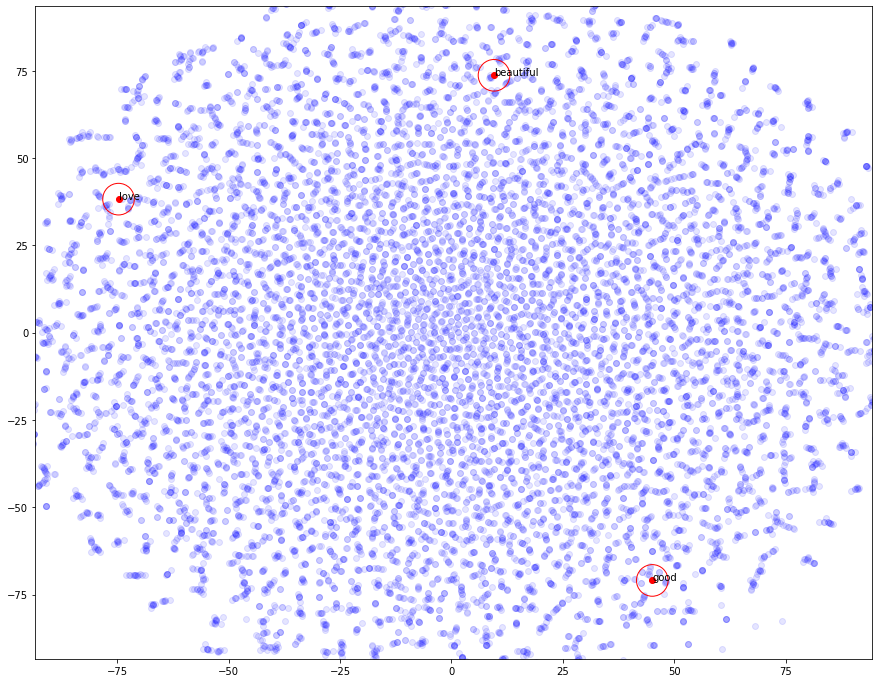

In [16]:
reduced_tSNE_ppmi = reduce_tSNE(ppmi_occurrence_matrix)
visualize_embeddings(reduced_tSNE_ppmi, ['good', 'love', 'beautiful'], word_to_idx)

In [37]:
benchmark_path = os.path.join(os.getcwd(), 'Benchmark')
valid_data_benchmark_path = os.path.join(benchmark_path, 'co-occurrence_count_benchmark', "{}.npy")

ppmi_occurrence_matrix = np.load(valid_data_benchmark_path.format('valid_co-occurrence_matrix_ppmi'))

print('PPMI Co-occurrence matrix shape: ', ppmi_occurrence_matrix.shape)

PPMI Co-occurrence matrix shape:  (13218, 13218)


### Visualization (cont'd)

Let's see if these weighting techniques have brought some change at visualization level!

Pick a dimensionality reduction technique and explore the new embedding space.

In [ ]:
### YOUR CODE HERE ###

Feel free to play with visualization!

In [ ]:
### YOUR CODE HERE ###

### [Let's play!] Embedding properties (cont'd)

Choose a word embedding property to analyse (synonyms, analogies, bias) and either select and describe a new example or pick an old one and compare previously achieved results with current ones!

In [ ]:
### YOUR CODE HERE  ###

# [Part II] Dense embeddings

Until now we've worked with sparse embedding methods, which lead to high dimensional word embeddings (dimension equal to |V|). The main drawback of such approach is that words belong to separate dimensions. Thus, in order to check if two words have similar contexts we need to have a large corpus available.

To this end, we might prefer a dense embedding technique, such that all words are encoded to high dimensional space, much smaller than |V| (generally up to $\sim$ 1000). A dense representation is also convenient from a machine learning point of view: we have fewer parameters to learn and, thus, models are less prone to overfitting. Moreover, words do not belong to separate dimensions anymore and semantic relationships are easily modelled.

In this section, we will experiment with pre-trained dense embedding models and compare them to previously described sparse methods.

## Working with a pre-trained model

The first step consists in choosing and downloading a pre-trained embedding model. For the purpose of this assignment, we limit to classic models, such as Word2Vec and GloVe.

Furthermore, some pre-trained embedding model versions may be quite resource demanding, depending on the embedding dimension and on the vocabulary size. We recommend sticking to low dimensional spaces (50, 100, 200) to avoid being stuck waiting for too much time.

### Download embedding model

Downloading a pre-trained embedding model is quite simple to due existing ad hoc wrappers. In particular, we will use [Gensim](https://radimrehurek.com/gensim/) library for both embedding models as follows.

In [38]:
import gensim
import gensim.downloader as gloader

def load_embedding_model(model_type, embedding_dimension=50):
    """
    Loads a pre-trained word embedding model via gensim library.

    :param model_type: name of the word embedding model to load.
    :param embedding_dimension: size of the embedding space to consider

    :return
        - pre-trained word embedding model (gensim KeyedVectors object)
    """

    download_path = ""

    # Find the correct embedding model name
    if model_type.strip().lower() == 'word2vec':
        download_path = "word2vec-google-news-300"

    elif model_type.strip().lower() == 'glove':
        download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)

    else:
        raise AttributeError("Unsupported embedding model type! Available ones: word2vec, glove")

    # Check download
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Word2Vec: 300")
        print("Glove: 50, 100, 200, 300")
        raise e

    return emb_model


# Modify these variables as you wish!
# Glove -> 50, 100, 200, 300
# Word2Vec -> 300
embedding_model_type = "glove"
embedding_dimension = 50

embedding_model = load_embedding_model(embedding_model_type, embedding_dimension)
        

### Out of vocabulary (OOV) words

Before evaluating pre-trained dense word embeddings, it is good practice to check if the model is consistent with our dataset. To do so, we check the number of out-of-vocabulary (OOV) terms.

If the OOV amount is negligible, we can just keep going. On the other hand, we might want to handle OOV terms by assigning them a specific word vector.

**Which one?** One common practice is to assign a random vector, since the embedding model will be part of a deep learning model and, thus, word vectors might be trained during the learning process. Even if that is the case, we can assign an embedding that is more meaningful rather than a random one: for example, we can identify the word embedding of an OOV term as the mean of its neighbour word embeddings.

Check out OOV terms and assign a meaningful word embedding. Then, at the visualization step, check if this strategy reflects words semantic properties.

In [39]:
# Function definition

def check_OOV_terms(embedding_model, word_listing):
    """
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms.

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_listing: dataset specific vocabulary (list)

    :return
        - list of OOV terms
    """

    ### YOUR CODE HERE ###
    model_vocab_array = np.array(list(embedding_model.vocab.keys()))
    word_listing_array = np.array(list(word_listing))
    return list(np.setdiff1d(word_listing_array, model_vocab_array))

oov_terms = check_OOV_terms(embedding_model, word_listing)

print("Total OOV terms: {0} ({1:.2f}%)".format(len(oov_terms), float(len(oov_terms)) / len(word_listing)))


Total OOV terms: 1783 (0.13%)


### Handling OOV words

Now we proceed on building the embedding matrix, while handling OOV terms at the same time. 

Experiment with/without the OOV custom encoding strategy.

**NOTE**: Here we ask you to implement both OOV strategies! Feel free to either write two separate functions or modify the given function signature.

In [40]:
# Function definition

def build_embedding_matrix(embedding_model, embedding_dimension, word_to_idx, oov_terms, co_occurrence_count_matrix):
    """
    Builds the embedding matrix of a specific dataset given a pre-trained word embedding model

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_to_idx: vocabulary map (word -> index) (dict)
    :param oov_terms: list of OOV terms (list)
    :param co_occorruence_count_matrix: the co-occurrence count matrix of the given dataset (window size 1)

    :return
        - embedding matrix that assigns a high dimensional vector to each word in the dataset specific vocabulary (shape |V| x d)
    """

    ### YOUR CODE HERE ###
    words = np.array(list(word_to_idx.keys()))
    embedding_matrix = np.zeros((len(words), embedding_dimension))
    for idx, w in enumerate(words):
        if w not in oov_terms:
            embedding_matrix[idx, :] = np.array(embedding_model.wv[w])
        elif idx < len(words) and idx > 0:
            # get the first 2 word in the vocav
            below_idx = -1
            up_idx = -1
            model_vocab = list(embedding_model.vocab.keys())
            
            for i in range(idx + 1, len(words)):
                if idx_to_word[i] in model_vocab:
                    below_idx = i
                    up_idx = i
                    break
            
            #up_idx = -1
            for k in reversed(range(0, idx - 1)):
                if idx_to_word[k] in model_vocab:
                    up_idx = k
                    below_idx = k
                    break
            
            up_embed = np.array(embedding_model.wv[idx_to_word[up_idx]])
            below_embed = np.array(embedding_model.wv[idx_to_word[below_idx]])
            mean_oov_word = np.mean((up_embed, below_embed), axis=0)
            embedding_matrix[idx, :] = mean_oov_word
    return embedding_matrix
# Testing

embedding_matrix = build_embedding_matrix(embedding_model, embedding_dimension, word_to_idx, oov_terms, co_occurrence_matrix)

print("Embedding matrix shape: {}".format(embedding_matrix.shape))


/home/pptr/.conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/pptr/.conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:41: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/pptr/.conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


Embedding matrix shape: (13218, 50)


## Embedding visualization (cont'd)

We are now ready to visualize pre-trained word embeddings!

In [ ]:
### YOUR CODE HERE ###

Feel free to play with visualization!

In [ ]:
### YOUR CODE HERE ###

## [Let's play!] Embedding properties (cont'd)

Choose a word embedding property to analyse (synonyms, analogies, bias) and either select and describe a new example or pick an old one and compare previously achieved results with current ones!

In [ ]:
### YOUR CODE HERE  ###

# Contact

For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

* Andrea Galassi -> a.galassi@unibo.it
* Federico Ruggeri -> federico.ruggeri6@unibo.it

Professor:

* Paolo Torroni -> p.torroni@unibo.it

Don't forget that your feedback is very important! Your suggestions help us improving course material.

# FAQ

---

**Q: Is it ok if I work with a small slice of the dataset?**

**A:** Yes, it is perfectly ok! The aim of this assignment is to look at word embedding methods and assess semantic properties. Large datasets usually imply large vocabularies and efficient sparse encoding methods have to be considered. Since such methods (see scipy documentation) might be complex to handle (especially under a colab session), you are free to work with small corpora.

---

**Q: Do I have to use both dimensionality reduction methods?**

**A:** Just one is fine! We suggest to try both of them at least once!

---

**Q: I'm struggling find good examples for analogies, bias and other scenarios!**

**A:** It is perfectly fine, this is just a simple example where we want you to look at
different encoding methods. Try to find at least one example that sounds good to you and motivate obtained results. Most probably, you won't find a perfect corrispondence of your expectations, but for us what's important is that you develop a critic approach, baring in mind that data has to explored before anything else.

---

**Q: Isn't stopwords removal excessive?**

**A:** Indeed, removing all stopwords might alter sentence meaning! However, they also alter co-occurrence matrices due to their high frequency. Not ignoring them leads to poor results when considering semantic properties. It's up to you whether removing or keeping stopwords! (remember to comment the corresponding method under [Some Cleaning](https://colab.research.google.com/drive/1UkGz0vdhPXh9NeApG7mYtY6e-jRcR3if#scrollTo=2TLTu0-2JQwi&line=3&uniqifier=1) section.

---

**Q: Can we modify functions signature?**

**A:** Functions that you have to complete can be modified as you please! Current functions definition should consider all required inputs in most cases.

---

**Q: Can we modify the dataset slicing step**

**A:** Yes, of course! The current slicing is just one possibility.

---
